In [ ]:
import os, sys
sys.path.append("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
from types import SimpleNamespace
import math, json
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import lovely_tensors as lt
from einops import rearrange
from PIL import Image, ImageDraw, ImageOps
import torch
lt.monkey_patch()
from safetensors.torch import load_file

from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import vae_decode
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model, attn_cache
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.wan_generate_video import merge_lora_weights
from preproc_utils import get_text_preproc, preproc_mask, draw_bboxes, get_mask_from_bboxes, prepare_image_inputs, prepare_control_inputs, prepare_control_inputs_for_entity, postproc_imgs
from attn_utils import get_pltplot_as_pil, get_text_inds_from_dict, get_attn_map

# sys.path.append("/home/yo564250/workspace/whisperer/utils")
# from img_utils import convert_from_qwen2vl_format
# from vistory_utils import StoryDataset

device = torch.device('cuda')

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:root:Xformers is not installed!
INFO:root:Flash Attn is installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention


In [2]:
%%time

dit_path = "/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors"
vae_path = "/home/yo564250/workspace/ComfyUI/models/vae/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "/home/yo564250/workspace/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "/home/yo564250/workspace/ComfyUI/models/text_encoders/clip_l.safetensors"
image_encoder_path = "/home/yo564250/workspace/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors"
lora_path = "/home/yo564250/workspace/ComfyUI/models/Lora/framepack/bg_lora_1000.safetensors"
# lora_path = "/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/outputs/training/idmask_control_lora/idmask_control_lora_test3-000008.safetensors"

model = load_packed_model(device, dit_path, 'sageattn', device, has_image_proj=False)
model.to(device)
model.eval().requires_grad_(False)

merge_lora_weights(lora_framepack, model, 
    SimpleNamespace(
        lora_weight = [lora_path], lora_multiplier = [1.0], 
        include_patterns=None, exclude_patterns=None, lycoris=None,
        save_merged_model=False
    ), 
device, None)

vae = load_vae(vae_path, 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=text_encoder1_path), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=text_encoder2_path))
feature_extractor, image_encoder = load_image_encoders(SimpleNamespace(image_encoder=image_encoder_path))

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from /home/yo564250/workspace/ComfyUI/models/Lora/framepack/bg_lora_1000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules.
INFO:musubi_t

CPU times: user 19.5 s, sys: 18.2 s, total: 37.7 s
Wall time: 54.2 s


  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 1044, 3072] bf16 n=3207168 (6.1Mb) x∈[-15.625, 18.000] μ=-0.015 σ=0.711 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 21, 3072] bf16 n=64512 (0.1Mb) x∈[-4.576e+03, 484.000] μ=-0.031 σ=20.500 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-8.875, 19.000] μ=-0.105 σ=0.930 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 1065, 1065] bf16 n=1134225 (2.2Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 1044, 256] n=267264 (1.0Mb) x∈[-1.000, 1.000] μ=0.358 σ=0.610 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'clean_latents': [(0, 144)], 'noise': [(144, 1044)], 'text_embeddings': [(1044, 1065)]})


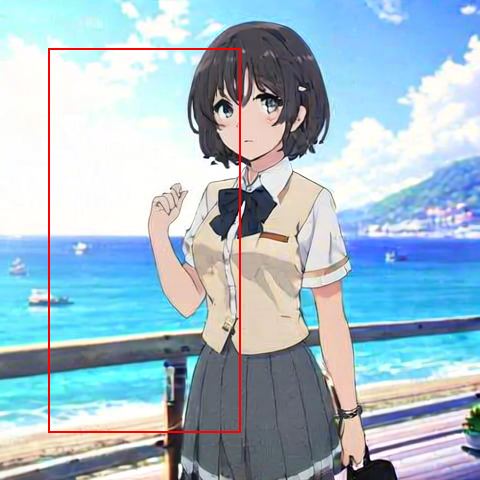

In [7]:
prompt = 'An anime-style girl wearing a school uniform and ribbon tie is walking along the seaside from a distance.'
height, width = 480, 480
entity_prompts = [] # ["An anime-style girl wearing a school uniform and ribbon tie"]
entity_bboxes = [[ 0.1, 0.1, 0.5, 0.9 ]]
control_image_paths = ["../../docs/fg_sample.jpg"]
target_index = [0]
control_indices = [0]

text_kwargs = get_text_preproc(prompt, 
    text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=entity_prompts, device=device)
entity_masks = [get_mask_from_bboxes(entity_bboxes, width, height)]
entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entity_masks], 1)

control_kwargs, control_nps = prepare_control_inputs_for_entity(
    control_image_paths, entity_bboxes, 480, 480, vae,
    control_indices=control_indices)
control_kwargs['clean_latent_bbox'] = torch.tensor(control_kwargs['clean_latent_bbox'], dtype=torch.float32)

num_inference_steps=25
seed = np.random.randint(2**31) # 1816186073 2105350387 1989424941
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

cache_layers = ['transformer_blocks.2', 'transformer_blocks.8', 'transformer_blocks.14']
use_attention_masking = ["mask_control"]

attn_cache.clear()
results = sample_hunyuan(
    transformer=model, sampler='unipc', width=width, height=height, frames=1, batch_size=1,
    real_guidance_scale=1.0, distilled_guidance_scale=10.0, guidance_rescale=0.0, shift=None,
    num_inference_steps=num_inference_steps,
    generator=generator, device=device, dtype=torch.bfloat16, cache_results = True, 
    cache_layers = cache_layers, 
    use_attention_masking = use_attention_masking, 
    entity_masks = entity_masks,
    **text_kwargs, 
    **control_kwargs
)

history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() 
    for i in range(results.shape[2])
], dim=2)
result_imgs = postproc_imgs(history_pixels)
draw_bboxes(Image.fromarray(result_imgs[0]), entity_bboxes)

  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 2296, 3072] bf16 n=7053312 (13Mb) x∈[-13.312, 12.812] μ=-0.013 σ=0.711 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 192, 3072] bf16 n=589824 (1.1Mb) x∈[-3.600e+03, 494.000] μ=0.053 σ=11.750 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-8.375, 19.125] μ=-0.103 σ=0.922 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 2488, 2488] bf16 n=6190144 (12Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 2296, 256] n=587776 (2.2Mb) x∈[-1.000, 1.000] μ=0.319 σ=0.631 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'clean_latents': [(0, 256)], 'noise': [(256, 2296)], 'text_embeddings': [(2296, 2488)]})
/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/practice/../musubi_tuner/frame_pack/hunyuan_video_packed.py:794: UserWarning: You are using Attention Mask, but sageattn does not support attention masking. Moving to 

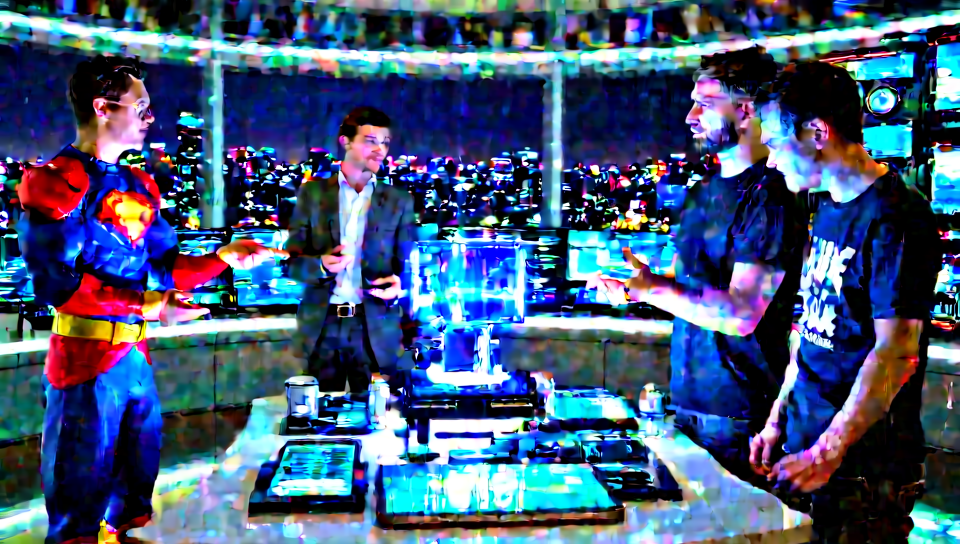

In [25]:
# Image.fromarray(
#   control_kwargs['target_latent_masks_1x68x120_float16'][:,0,:,:].permute(1,2,0).cpu().numpy().astype(bool)[...,0]
# ).resize((960,544))

dset_path = Path("/groups/chenchen/patrick/OpenS2V-Nexus/datasets")
dset_name = "test3_2"
name = "zYwOTomP5EE_segment_59_step1-12-125_step2-12-113_step4_step5_step6"
width, height = 960, 544
c_H, c_W = 256, 256
keys = [0]

meta = OmegaConf.load(dset_path / f"{dset_name}/{name}/meta.yaml")
entity_bboxes = [meta['target_body'][str(x)] for x in keys]
entity_bboxes = [[x[0]/meta['width'], x[1]/meta['height'], x[2]/meta['width'], x[3]/meta['height']] for x in entity_bboxes]
clean_latent_bboxes = [[bbox[0], bbox[1], bbox[0]+(c_H / height), bbox[1]+(c_W / width)] for bbox in entity_bboxes]

text_kwargs = load_file(dset_path / f"{dset_name}_cache/{name}_fp_te.safetensors")
control_kwargs = load_file(dset_path / f"{dset_name}_cache/{name}_1280x0720_fp.safetensors")

seed = np.random.randint(2**31)
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

attn_cache.clear()
results = sample_hunyuan(
    transformer=model, sampler='unipc', width=width, height=height, frames=1, batch_size=1,
    real_guidance_scale=1.0, distilled_guidance_scale=10.0, guidance_rescale=0.0, shift=None,
    num_inference_steps=25, generator=generator, device=device, dtype=torch.bfloat16, 
    cache_results = True, cache_layers = [], 
    use_attention_masking = ["mask_control", "mask_entities"], 
    entity_masks = control_kwargs['target_latent_masks_1x68x120_float16'].unsqueeze(0).to(device, dtype=torch.float32),
    prompt_embeds = text_kwargs['llama_vec_float16'].unsqueeze(0).to(device, dtype=torch.bfloat16),
    prompt_embeds_mask = text_kwargs['llama_attention_mask'].unsqueeze(0).to(device, dtype=torch.bool),
    prompt_poolers = text_kwargs['clip_l_pooler_float32'].unsqueeze(0).to(device, dtype=torch.bfloat16),
    clean_latents = control_kwargs['latents_clean_1x68x120_float16'].unsqueeze(0).to(device, dtype=torch.bfloat16),
    clean_latent_indices = control_kwargs['clean_latent_indices_int64'].unsqueeze(0).to(device, dtype=torch.int64),
    # clean_latent_bbox = control_kwargs['clean_latent_bbox'].unsqueeze(0).to(device, dtype=torch.float32),
    clean_latent_bbox = clean_latent_bboxes,
    clean_latents_2x = None,
    clean_latent_2x_indices = None,
    clean_latents_4x = None,
    clean_latent_4x_indices = None,
    latent_indices = control_kwargs['latent_indices_int64'].unsqueeze(0).to(device, dtype=torch.int64),
)

history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() 
    for i in range(results.shape[2])
], dim=2)
result_imgs = postproc_imgs(history_pixels)
Image.fromarray(result_imgs[0])

  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 2296, 3072] bf16 n=7053312 (13Mb) x∈[-13.312, 12.812] μ=-0.013 σ=0.711 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 192, 3072] bf16 n=589824 (1.1Mb) x∈[-3.600e+03, 494.000] μ=0.053 σ=11.750 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-8.375, 19.125] μ=-0.103 σ=0.922 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 2488, 2488] bf16 n=6190144 (12Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 2296, 256] n=587776 (2.2Mb) x∈[-1.000, 1.000] μ=0.330 σ=0.626 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'clean_latents': [(0, 256)], 'noise': [(256, 2296)], 'text_embeddings': [(2296, 2488)]})
/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/practice/../musubi_tuner/frame_pack/hunyuan_video_packed.py:794: UserWarning: You are using Attention Mask, but sageattn does not support attention masking. Moving to 

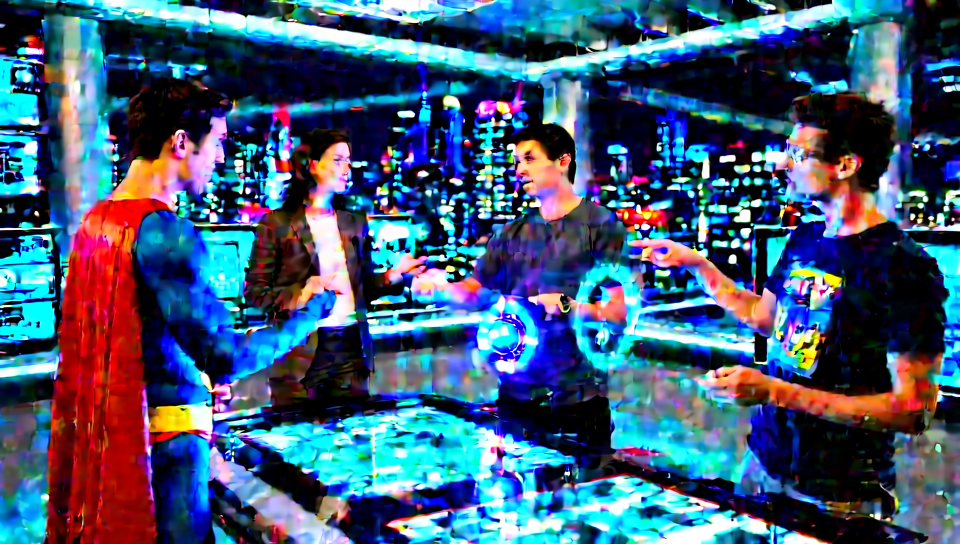

In [ ]:
dset_path = Path("/groups/chenchen/patrick/OpenS2V-Nexus/datasets")
dset_name = "test3_2"
name = "zYwOTomP5EE_segment_59_step1-12-125_step2-12-113_step4_step5_step6"
width, height = 960, 544

meta = OmegaConf.load(dset_path / f"{dset_name}/{name}/meta.yaml")
text_kwargs = load_file(dset_path / f"{dset_name}_cache/{name}_fp_te.safetensors")
control_kwargs = load_file(dset_path / f"{dset_name}_cache/{name}_1280x0720_fp.safetensors")

seed = np.random.randint(2**31)
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

attn_cache.clear()
results = sample_hunyuan(
    transformer=model, sampler='unipc', width=width, height=height, frames=1, batch_size=1,
    real_guidance_scale=1.0, distilled_guidance_scale=10.0, guidance_rescale=0.0, shift=None,
    num_inference_steps=25, generator=generator, device=device, dtype=torch.bfloat16, 
    cache_results = True, cache_layers = [], 
    use_attention_masking = ["mask_control", "mask_entities"], 
    entity_masks = control_kwargs['target_latent_masks_1x68x120_float16'].unsqueeze(0).to(device, dtype=torch.float32),
    prompt_embeds = text_kwargs['llama_vec_float16'].unsqueeze(0).to(device, dtype=torch.bfloat16),
    prompt_embeds_mask = text_kwargs['llama_attention_mask'].unsqueeze(0).to(device, dtype=torch.bool),
    prompt_poolers = text_kwargs['clip_l_pooler_float32'].unsqueeze(0).to(device, dtype=torch.bfloat16),
    clean_latents = control_kwargs['latents_clean_1x68x120_float16'].unsqueeze(0).to(device, dtype=torch.bfloat16),
    clean_latent_indices = control_kwargs['clean_latent_indices_int64'].unsqueeze(0).to(device, dtype=torch.int64),
    # clean_latent_bbox = control_kwargs['clean_latent_bbox'].unsqueeze(0).to(device, dtype=torch.float32),
    clean_latents_2x = None,
    clean_latent_2x_indices = None,
    clean_latents_4x = None,
    clean_latent_4x_indices = None,
    latent_indices = control_kwargs['latent_indices_int64'].unsqueeze(0).to(device, dtype=torch.int64),
)

history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() 
    for i in range(results.shape[2])
], dim=2)
result_imgs = postproc_imgs(history_pixels)
Image.fromarray(result_imgs[0])

  0%|          | 0/25 [00:00<?, ?it/s]

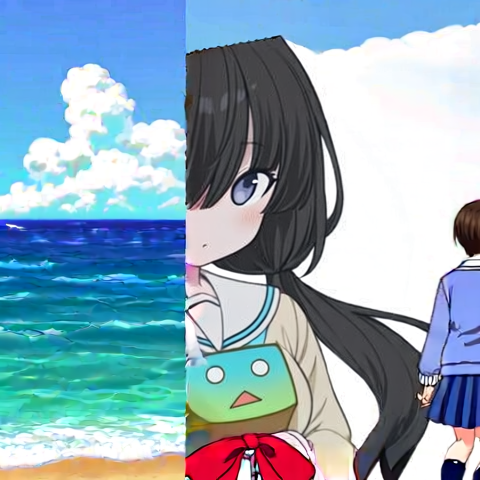

In [ ]:
prompt = 'An anime-style girl wearing a school uniform and ribbon tie is walking along the seaside from a distance.'
height, width = 480, 480

entity_prompts = ["An anime-style girl wearing a school uniform and ribbon tie"]
entity_bboxes = [[ 0.4, 0.1, 0.9, 0.9 ]]

control_image_paths = ["../../docs/fg_sample.jpg"]
target_index = [1]
control_indices = [0]

text_kwargs = get_text_preproc(prompt, 
    text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[], device=device)

entity_masks = [get_mask_from_bboxes(entity_bboxes, width, height)]
entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entity_masks], 1)

control_kwargs, control_nps = prepare_control_inputs_for_entity(
    control_image_paths, [[0.0, 0.0, 1.0, 1.0]], 480, 480, vae,
    control_indices=control_indices)

num_inference_steps=25
seed = np.random.randint(2**31)
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

attn_cache.clear()
results = sample_hunyuan(
    transformer=model, sampler='unipc', width=width, height=height, frames=1, batch_size=1,
    real_guidance_scale=1.0, distilled_guidance_scale=10.0, guidance_rescale=0.0, shift=None,
    num_inference_steps=num_inference_steps,
    generator=generator, device=device, dtype=torch.bfloat16, 
    cache_results = False, cache_layers = [], 
    use_attention_masking = ["mask_control"], 
    entity_masks = entity_masks,
    **text_kwargs, 
    latent_indices = torch.tensor([target_index], dtype=torch.int64),
    **control_kwargs
)

history_pixels = torch.cat([vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() for i in range(results.shape[2])], dim=2)
result_imgs = postproc_imgs(history_pixels)
Image.fromarray(result_imgs[0])

In [ ]:
print(attn_cache['attn_dict'])

attn_mask = attn_cache['attn_mask'].clone().to(dtype=torch.float32)
attn_mask = get_pltplot_as_pil(attn_mask.cpu().numpy()[0], vmin=-9999., vmax=0., cmap=plt.cm.gray)

timesteps = sorted(list(attn_cache['transformer_blocks.14'].keys()), reverse=False)
token_H, token_W = height // 16, width // 16
token_C = len(control_indices + target_index)

control_inds = attn_cache['attn_dict']['clean_latents']
noise_inds = attn_cache['attn_dict']['noise'][-1]
text_inds = attn_cache['attn_dict']['text_embeddings']

fig, ax = plt.subplots(len(cache_layers), 3, figsize=(18, 18))
with torch.inference_mode():
    for i, block in enumerate(cache_layers):
        attention_map = []
        for t in range(0,25,5):
            attention_prob = attn_cache[block][timesteps[t]]
            attention_prob = attention_prob[:,:,:noise_inds[1],:].to(device)
            attention_map.append(attention_prob)
        attention_map = torch.stack(attention_map, dim=0).mean(dim=0) # B A (CHW) D
        attention_map = attention_map[:,:,noise_inds[0]:noise_inds[1]].sum(1).squeeze(1).permute(0,2,1)
        attention_map = rearrange(attention_map, 'B D (H W) -> B D H W', H=token_H, W=token_W)

        control_attention_data = attention_map[0,control_inds[-1][0]:control_inds[-1][1],:,:].mean(axis=0).to(dtype=torch.float32).cpu().numpy()
        control_attention_image = get_pltplot_as_pil(control_attention_data).resize((width,height))

        entity_attention_data = attention_map[0,text_inds[-1][0]:text_inds[-1][1],:,:].mean(axis=0).to(dtype=torch.float32).cpu().numpy()
        entity_attention_image = get_pltplot_as_pil(entity_attention_data).resize((width,height))

        text_attention_data = attention_map[0,1125:1135,:,:].mean(axis=0).to(dtype=torch.float32).cpu().numpy()
        text_attention_image = get_pltplot_as_pil(text_attention_data).resize((width,height))

        ax[i, 0].set_title(f"Layer {block.split('.')[-1]} - Ref")
        ax[i, 1].set_title(f"Layer {block.split('.')[-1]} - Entity")
        ax[i, 2].set_title(f"Layer {block.split('.')[-1]} - Global corr")
        ax[i, 0].imshow(control_attention_image)
        ax[i, 1].imshow(entity_attention_image)
        ax[i, 2].imshow(text_attention_image)
        ax[i, 0].set_xticks([])
        ax[i, 1].set_xticks([])
        ax[i, 2].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].set_yticks([])
        ax[i, 2].set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
attn_images = get_attn_map(
    {k:v for k,v in attn_cache.items() if k.startswith("transformer_blocks")}, 
    [3,24], 
    block_id=f'transformer_blocks.2', 
    token_type = 'text',
    height=height, width=width, token_C=len(control_indices + target_index),
    embed_size = 729,
    t_0=0, t_1=25)
attn_images.resize((120,120))

In [ ]:
vistory_dataset = StoryDataset(Path("/groups/chenchen/patrick/ViStoryBench/ViStoryBench"))
story_num = '05'
shot_num = 1

# case = Path("/data/whisperer/outputs/20250717_154000/[PANEL-1]")
# case_config = json.loads((case.parent / "config.json").read_text())
# layout = json.loads((case.parent / "pose_layout.json").read_text())[case.name]
# width, height = layout['bbox'][2] - layout['bbox'][0], layout['bbox'][3] - layout['bbox'][1]
# # width, height = getres(width, height, target_area=960*960, div_factor=16)

story = vistory_dataset.load_story(story_num)
characters = vistory_dataset.load_characters(story_num)
story_shot = story['shots'][shot_num]
characters_shot = {k: characters[k] for k in story_shot['character_name']}